In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import keras

from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.__version__

'2.2.0'

In [3]:
train_df=pd.read_csv('../data/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/mitbih_test.csv',header=None)

In [4]:
target_train = train_df[187]
target_test = test_df[187]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [5]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# print('Antes del reshaping: ', X_train.shape)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print('Despues del reshaping: ')
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

Despues del reshaping: 
X_train: (87554, 186, 1)
X_test: (21892, 186, 1)


In [13]:
X_length = X_train.shape[0]
coef = 0.3
limit = int(X_length * coef)

X_val = X_train[:limit]
y_val = y_train[:limit]
X_train = X_train[limit:]
y_train = y_train[limit:]

In [15]:
model = Sequential()

model.add(Convolution1D(32, (6), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Flatten())

model.add(Dense(5, activation='softmax', name='main_output'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='conv_model2.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=256,validation_data=(X_val,y_val))

Epoch 1/40
240/240 [==============================] - 33s 138ms/step - loss: 0.2642 - accuracy: 0.9243 - val_loss: 3.7641 - val_accuracy: 0.0000e+00
Epoch 2/40
240/240 [==============================] - 33s 139ms/step - loss: 0.1374 - accuracy: 0.9607 - val_loss: 1.4089 - val_accuracy: 0.3789
Epoch 3/40
240/240 [==============================] - 34s 140ms/step - loss: 0.1099 - accuracy: 0.9675 - val_loss: 0.0923 - val_accuracy: 0.9724
Epoch 4/40
240/240 [==============================] - 34s 142ms/step - loss: 0.0953 - accuracy: 0.9725 - val_loss: 0.0298 - val_accuracy: 0.9941
Epoch 5/40
240/240 [==============================] - 34s 140ms/step - loss: 0.0897 - accuracy: 0.9733 - val_loss: 0.0513 - val_accuracy: 0.9881
Epoch 6/40
240/240 [==============================] - 36s 148ms/step - loss: 0.0808 - accuracy: 0.9759 - val_loss: 0.0444 - val_accuracy: 0.9885
Epoch 7/40
240/240 [==============================] - 34s 141ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.0335 - va

In [16]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 97.92%


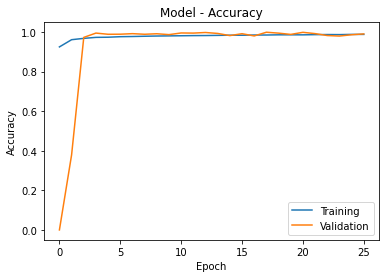

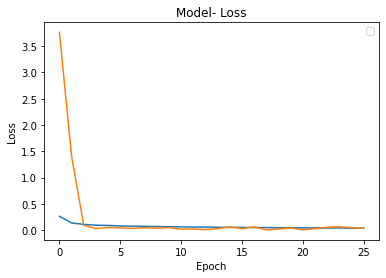

In [17]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [21]:
# model_name = 'best_model.h5'
# model = keras.models.load_model(f'../model/{model_name}')

y_pred = model.predict(X_test)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 181, 32)           224       
_________________________________________________________________
batch_normalization_6 (Batch (None, 181, 32)           128       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 91, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 89, 32)            3104      
_________________________________________________________________
batch_normalization_7 (Batch (None, 89, 32)            128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 43, 32)           

In [40]:
def get_max_index_list(x):
    return [np.where(i == np.amax(i))[0][0] for i in x]

In [46]:
y_test_list = get_max_index_list(y_test)
y_pred_list = get_max_index_list(y_pred)

print("Precision", precision_score(y_test_list, y_pred_list, average='macro'))
print("Recall", recall_score(y_test_list, y_pred_list, average='macro'))
print("f1_score", f1_score(y_test_list, y_pred_list, average='macro'))

Precision 0.900505041809892
Recall 0.8947012947838708
f1_score 0.8975119560551106


Normalized confusion matrix


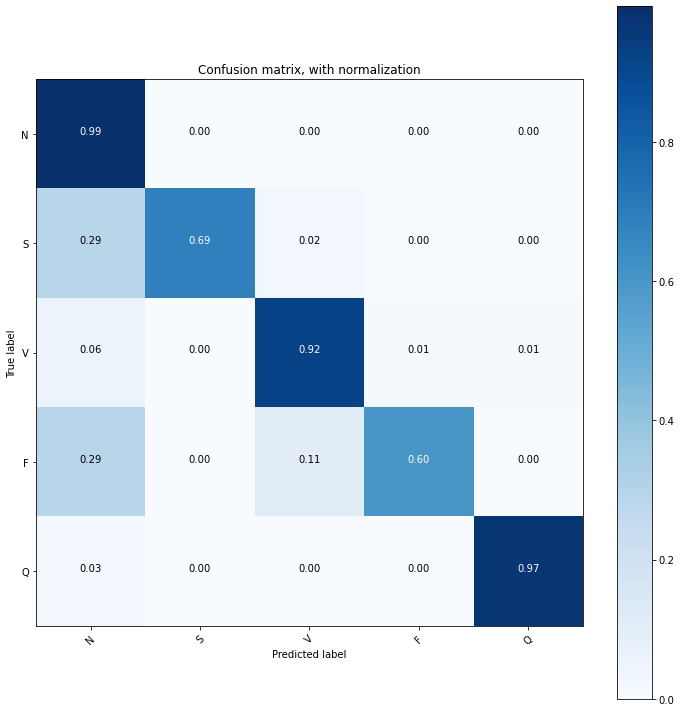

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()